## Projected Experiments

**NOTE:** Please confirm the results in this notebook after making any changes to the repository.

This notebook is written to demonstrate LID estimation on the set of projected datasets. There are two types of datasets here:

1. Data that is generated by first sampling a `k` dimensional vector from a distribution and then performing a linear projection to `d` dimensions. This is the `k`-to-`d` projection.
2. Data that is a mixture of one or more `k`-to-`d` projections. This is the `k`-to-`d` mixture.

The first type of dataset has a global intrinsic dimensionality. We can use our LID estimator and compare it to the global intrinsic dimensionality, and also benchmark against other methods that estimate intrinsic dimensionality. However, the second type of dataset has different dimensionality based on the proximity to the different projections. In this case, we can only use our LID estimator to estimate the local intrinsic dimensionality.


In [3]:
import sys
sys.path.append('..')
import torch
import matplotlib.pyplot as plt
from model_zoo.datasets.generated import Lollipop
%load_ext autoreload
%autoreload 2

# set to change device:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)

/home/hamid/miniconda3/envs/ood-detection/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Single Projected Dataset

Here, we train flow and diffusion models on a single projected dataset. We then use the trained models to estimate the intrinsic dimensionality of the dataset.

In [49]:
%autoreload 2
from model_zoo.datasets.generated import LinearProjectedDataset

colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink']
manifold_dims = [50, 80, 100, 160, 200, 400, 800]
ambient_dim = 800
projected_datasets = []

for manifold_dim in manifold_dims:
    dset = LinearProjectedDataset(
        name='projected',
        role='train',
        seed=42,
        manifold_dim=manifold_dim,
        ambient_dim=ambient_dim,
        projection_type='repeat',
        size=100000,
        sample_distr='normal',
    )
    projected_datasets.append(dset)


## LPCA experiments

Here, we will find the intrinsic dimensionality of all these datasets with the LPCA method. We will then compare the results with the LID method.

In [45]:
import skdim

lpca_estimates = []

for dset in projected_datasets:
    lpca_estimator = skdim.id.lPCA()
    lpca_estimator.fit(dset.x.cpu()[:5000].numpy())
    lpca_estimates.append(lpca_estimator.dimension_)
lpca_estimates
    

[50, 80, 100, 160, 200, 400, 800]

### Flow experiments

Here, we train a flow model to fit the lollipop dataset. We then use the flow model to generate samples and estimate LID on the generated samples.

In [46]:
%autoreload 2
from torch import optim
from model_zoo.density_estimator import NormalizingFlow
from dimensions.flow_fast_lid import FastFlowLID
import torch
from tqdm import tqdm

model_kwargs = {
    # Data transform args (they are here because they might influence log_prob)
    'flatten': False,
    'data_shape': [ambient_dim],

    'denoising_sigma': None,
    'dequantize': False,
    'scale_data': False,
    'whitening_transform': False,
    'logit_transform': False,
    'clamp_samples': False,

    # Base distribution arguments (in this work the base is always Gaussian)
    'base_distribution' : {
        'class_path': 'nflows.distributions.StandardNormal',
        'init_args': {
            'shape': [ambient_dim],
        }
    },

    'transform': [
        {
            'repeat_n': 1,
            'content': [
                {
                    'class_path': 'nflows.transforms.normalization.ActNorm',
                    'init_args': {'features': 2}
                },
                {
                    'class_path': 'model_zoo.density_estimator.flow.ConfigurableCouplingTransform',
                    'init_args': { 
                        'coupling_transform_cls': 'nflows.transforms.PiecewiseRationalQuadraticCouplingTransform',
                        'net': {
                            'class_path': 'nflows.nn.nets.resnet.ResidualNet',
                            'init_args': {
                                'hidden_features': ambient_dim * 4,
                                'num_blocks': 3,
                            }
                        },
                        'mask': {
                            'dim': ambient_dim,
                            'flip': True,
                        },
                        'tails': 'linear',
                        'num_bins': 10,
                        'tail_bound': 50.0,
                    }
                },
                {
                    'class_path': 'nflows.transforms.normalization.ActNorm',
                    'init_args': {'features': ambient_dim},
                },
                {
                    'class_path': 'model_zoo.density_estimator.flow.ConfigurableCouplingTransform',
                    'init_args': {
                        'coupling_transform_cls': 'nflows.transforms.PiecewiseRationalQuadraticCouplingTransform',
                    
                        'net': {
                            'class_path': 'nflows.nn.nets.resnet.ResidualNet',
                            'init_args': {
                                'hidden_features': ambient_dim * 4,
                                'num_blocks': 3,
                            }
                        },
                        'mask': {
                            'dim': ambient_dim,
                            'flip': False,
                        },
                        
                        'tails': 'linear',
                        'num_bins': 10,
                        'tail_bound': 50.0,
                    }
                },
            ],
        },
    ],
}
# (1) Setup the model and optimizer
flow_models = [NormalizingFlow(**model_kwargs).to(device) for _ in range(len(projected_datasets))] # This class contains the actual diffusion logic
epochs = 1
batch_size = 100 # Here equal to the dataset size of 100
for i, __ in enumerate(list(zip(flow_models, projected_datasets))):
    flow_model, dset = __
    print(f"Training model on dataset [{i+1}/{len(projected_datasets)}]")
    optimizer = optim.Adam(flow_model.parameters(), lr=1e-3)
    # set a reduce on plateau learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.8, verbose=False)

    loss_history = []
    flow_model.train()
    rng = tqdm(range(epochs), desc = f"Initialize training for {epochs} epochs")
    for epoch in rng:
        split = dset.x.split(batch_size)
        for j, x in enumerate(split):
            rng.set_description(f"Training with batch {j+1}/{len(split)}")
            x = x.to(device)
            batch_size = x.shape[0]
            loss = flow_model.loss(x)
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()
        scheduler.step(loss)
        loss_history.append(loss.item())
        if len(loss_history) >= 2:
            rng.set_description(f"Training with average loss {sum(loss_history) / len(loss_history):.4f}")
            loss_history.clear()


Training model on dataset [1/7]


Training with batch 1000/1000: 100%|██████████| 1/1 [00:39<00:00, 39.02s/it]


Training model on dataset [2/7]


Training with batch 1000/1000: 100%|██████████| 1/1 [00:39<00:00, 39.07s/it]


Training model on dataset [3/7]


Training with batch 1000/1000: 100%|██████████| 1/1 [00:39<00:00, 39.07s/it]


Training model on dataset [4/7]


Training with batch 1000/1000: 100%|██████████| 1/1 [00:39<00:00, 39.07s/it]


Training model on dataset [5/7]


Training with batch 1000/1000: 100%|██████████| 1/1 [00:39<00:00, 39.08s/it]


Training model on dataset [6/7]


Training with batch 1000/1000: 100%|██████████| 1/1 [00:39<00:00, 39.11s/it]


Training model on dataset [7/7]


Training with batch 1000/1000: 100%|██████████| 1/1 [00:39<00:00, 39.09s/it]


Now let us perform the LID estimation with different scale parameters.

Calculating LID dataset [1/5]


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:08<00:00, 11.16it/s]


Calculating LID dataset [2/5]


100%|██████████| 100/100 [00:09<00:00, 11.04it/s]


Calculating LID dataset [3/5]


100%|██████████| 100/100 [00:09<00:00, 11.05it/s]


Calculating LID dataset [4/5]


100%|██████████| 100/100 [00:09<00:00, 11.04it/s]


Calculating LID dataset [5/5]


100%|██████████| 100/100 [00:09<00:00, 11.04it/s]


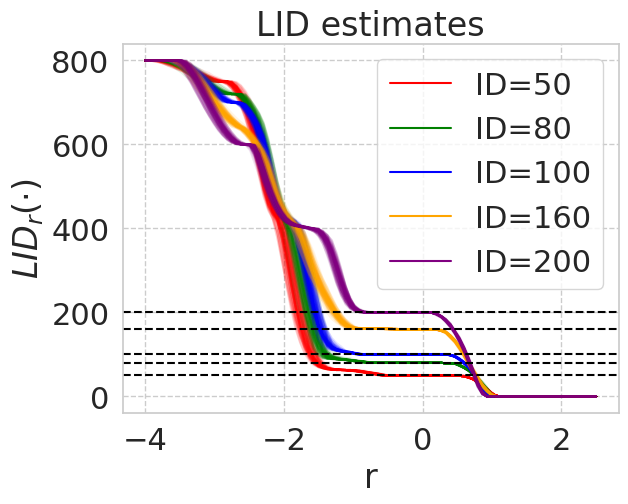

In [82]:

from matplotlib.lines import Line2D
import numpy as np

lid_estimators = [
    FastFlowLID(
        train_dataloader=0,
        valid_dataloader=0,
        test_dataloader=0,
        writer=0,
        ambient_dim=2,
        flow_model = flow_model, 
        device=device,
        submethod= 'jacobian_threshold',
    ) for flow_model in flow_models
]

for lid_estimator in lid_estimators:
    lid_estimator.setup_method()


def plot_multiscale_lid_flow(
    datasets,
    r_begin,
    r_end,
    lid_estimators, 
    colors,
    limit_dataset: int = 100, 
):

    all_model_all_lids = []
    for idx, lid_estimator in enumerate(lid_estimators):
        print(f"Calculating LID dataset [{idx+1}/{len(lid_estimators)}]")
        lid = []

        radii = np.linspace(r_begin, r_end, 100)
        first_time = True
        for r in tqdm(radii):
            all_lid = lid_estimator._calc_lid(datasets[idx].x.to(device)[:limit_dataset], r=r, use_cache=not first_time)
            first_time = False
            lid.append(all_lid)

        lid = np.stack(lid).T
        all_model_all_lids.append(lid)
        for i in range(len(lid)):
            plt.plot(radii, lid[i], color=colors[idx], alpha=0.1)
            

    # Creating custom legend
    legend_elements = [Line2D([0], [0], color=colors[i], label=f'ID={manifold_dims[i]}') for i in range(len(colors))]

    # Adding the legend to the plot
    plt.legend(handles=legend_elements)

    # Adding titles and labels (optional)
    plt.title("LID estimates")
    plt.xlabel("r" )
    plt.ylabel("$LID_{r}(\\cdot)$")
    
    return radii, all_model_all_lids



radii, all_model_all_lids = plot_multiscale_lid_flow(
    datasets=projected_datasets[:5],
    r_begin=-4,
    r_end=2.5,
    lid_estimators=lid_estimators[:5], 
    colors=colors[:5],
    limit_dataset=100,
)
for lpca_lid in lpca_estimates[:5]:
    plt.axhline(y=lpca_lid, color='black', linestyle='--')
plt.show()


<Axes: >

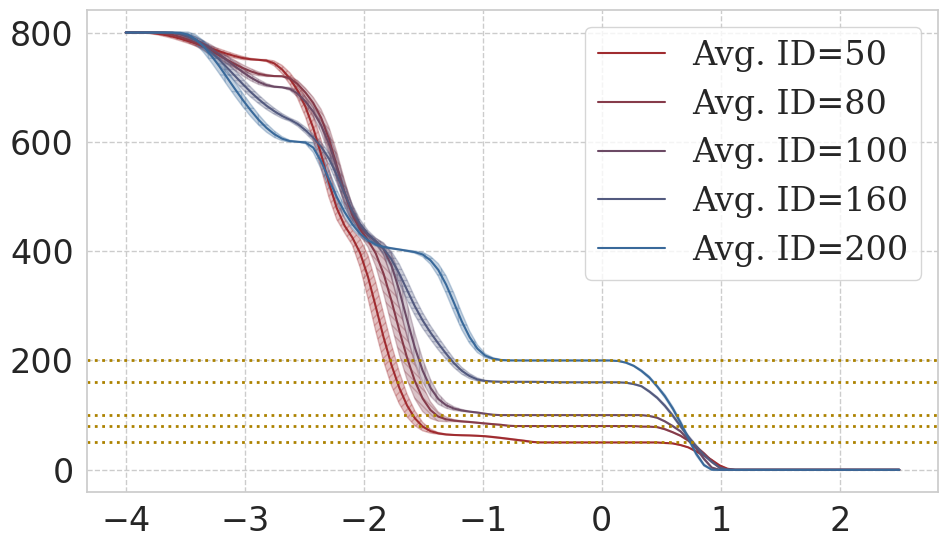

In [84]:

from pretty import plot_trends
from pretty import ColorTheme

plot_trends(
    t_values=radii,
    mean_values=[np.mean(lid, axis=0) for lid in all_model_all_lids],
    std_values=[np.std(lid, axis=0) for lid in all_model_all_lids],
    colors=[ColorTheme.OOD_to_IN_DISTR_0.value, ColorTheme.OOD_to_IN_DISTR_1.value, ColorTheme.OOD_to_IN_DISTR_2.value, ColorTheme.OOD_to_IN_DISTR_3.value, ColorTheme.OOD_to_IN_DISTR_4.value],
    labels= [f'ID={manifold_dims[i]}' for i in range(len(colors))],
    horizontal_lines_color=[ColorTheme.DARK_DENSITY.value for _ in range(5)],
    horizontal_lines_thickness=2,
    horizontal_lines=[lpca_estimates[i] for i in range(5)],
)
    

### Diffusion Experiments (VP-SDE)

In [48]:
%autoreload 2
from model_zoo.datasets.generated import LinearProjectedDataset
from torch import optim
from model_zoo.networks.toy import SimpleDiffusionMLP
from model_zoo.density_estimator.diffusions import VPSDE_Diffusion
import torch
from tqdm import tqdm

# (1) Setup the model and optimizer
vpsde_models = []
for _ in range(len(projected_datasets)):
    score_network = SimpleDiffusionMLP(800, hidden_sizes=(1024,))
    vpsde_model = VPSDE_Diffusion(score_network=score_network, data_shape=(800,))
    vpsde_models.append(vpsde_model.to(device)) # This class contains the actual diffusion logic
epochs = 200
batch_size = 100 # Here equal to the dataset size of 100
for i, __ in enumerate(list(zip(vpsde_models, projected_datasets))):
    vpsde_model, dset = __
    print(f"Training model on dataset [{i+1}/{len(projected_datasets)}]")
    optimizer = optim.AdamW(vpsde_model.parameters(), lr=5e-5)
    # set a reduce on plateau learning rate scheduler
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.8, verbose=False)

    loss_history = []
    vpsde_model.train()
    rng = tqdm(range(epochs), desc = f"Initialize training for {epochs} epochs")
    for epoch in rng:
        for x in dset.x.split(batch_size):
            x = x.to(device)
            batch_size = x.shape[0]
            loss = vpsde_model.loss(x)
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()
        # scheduler.step(loss)
        loss_history.append(loss.item())
        if len(loss_history) >= 2:
            rng.set_description(f"Training with average loss {sum(loss_history) / len(loss_history):.4f}")
            loss_history.clear()


Training model on dataset [1/7]


Training with average loss 119.8608: 100%|██████████| 200/200 [03:18<00:00,  1.01it/s]


Training model on dataset [2/7]


Training with average loss 147.4151: 100%|██████████| 200/200 [03:18<00:00,  1.01it/s]


Training model on dataset [3/7]


Training with average loss 148.6472: 100%|██████████| 200/200 [02:28<00:00,  1.35it/s]


Training model on dataset [4/7]


Training with average loss 196.9985: 100%|██████████| 200/200 [02:26<00:00,  1.36it/s]


Training model on dataset [5/7]


Training with average loss 197.4961: 100%|██████████| 200/200 [02:26<00:00,  1.36it/s]


Training model on dataset [6/7]


Training with average loss 216.1954: 100%|██████████| 200/200 [02:26<00:00,  1.36it/s]


Training model on dataset [7/7]


Training with average loss 223.1078: 100%|██████████| 200/200 [02:26<00:00,  1.36it/s]



In this section, we will train the variance preserving variant of diffusion model on the lollipop dataset and then use different LID estimation techniques on it.

Calculating LID dataset [1/5]


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [02:07<00:00,  1.28s/it]


Calculating LID dataset [2/5]


100%|██████████| 100/100 [02:08<00:00,  1.28s/it]


Calculating LID dataset [3/5]


100%|██████████| 100/100 [02:08<00:00,  1.28s/it]


Calculating LID dataset [4/5]


100%|██████████| 100/100 [02:07<00:00,  1.28s/it]


Calculating LID dataset [5/5]


100%|██████████| 100/100 [02:07<00:00,  1.28s/it]


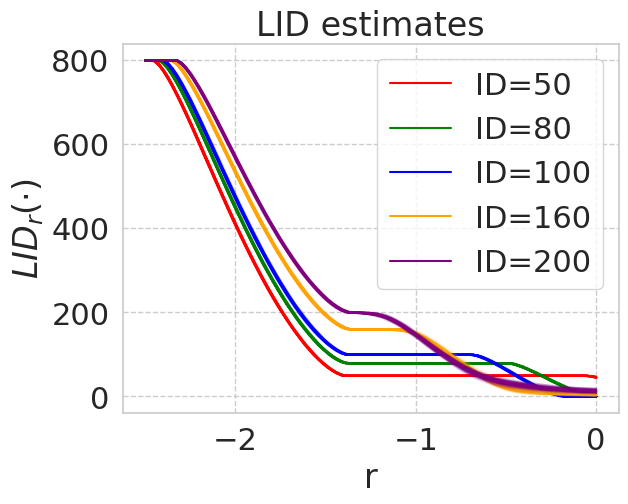

In [80]:

from matplotlib.lines import Line2D
import numpy as np


def plot_multiscale_lid_diffusion(
    datasets,
    r_begin,
    r_end,
    diffusion_models, 
    colors,
    limit_dataset: int = 100, 
):
    all_model_all_lids = []
    for idx, model in enumerate(diffusion_models):
        print(f"Calculating LID dataset [{idx+1}/{len(diffusion_models)}]")
        lid = []

        radii = np.linspace(r_begin, r_end, 100)
        first_time = True
        for r in tqdm(radii):
            all_lid = model.lid(
                datasets[idx].x[:limit_dataset].to(device), 
                r=r,
                num_samples=None,
                eps=0.001,
                use_cache=not first_time,
            )
            first_time = False
            lid.append(all_lid)
        lid = np.stack(lid).T
        all_model_all_lids.append(lid)
        for i in range(len(lid)):
            plt.plot(radii, lid[i], color=colors[idx], alpha=0.1)

    # Creating custom legend
    legend_elements = [Line2D([0], [0], color=colors[i], label=f'ID={manifold_dims[i]}') for i in range(len(colors))]

    # Adding the legend to the plot
    plt.legend(handles=legend_elements)

    # Adding titles and labels (optional)
    plt.title("LID estimates")
    plt.xlabel("r" )
    plt.ylabel("$LID_{r}(\\cdot)$")

    plt.show()
    return radii, all_model_all_lids
    

radii, all_model_all_lids = plot_multiscale_lid_diffusion(
    projected_datasets[:5],
    -2.5,
    0,
    vpsde_models[:5], 
    colors[:5],
    limit_dataset=100,
)

<Axes: >

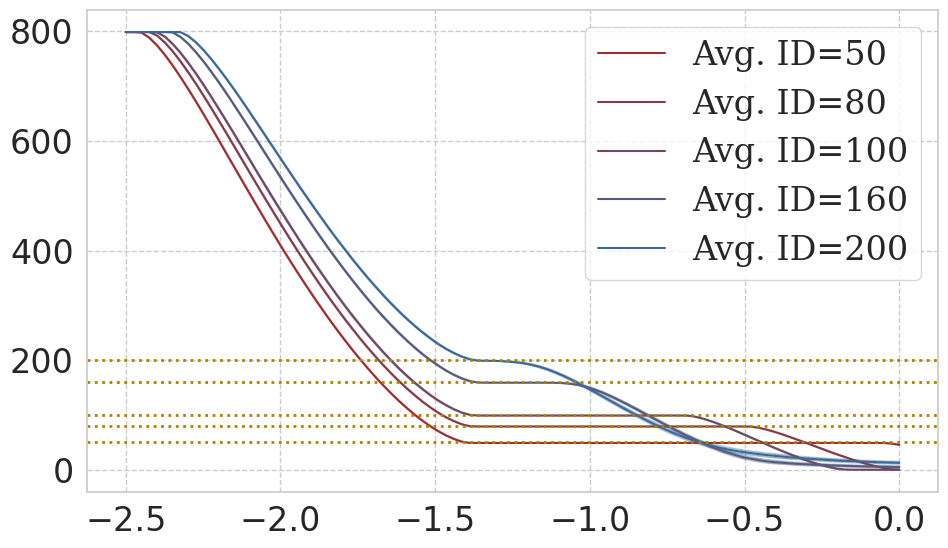

In [81]:

from pretty import plot_trends
from pretty import ColorTheme

plot_trends(
    t_values=radii,
    mean_values=[np.mean(lid, axis=0) for lid in all_model_all_lids],
    std_values=[np.std(lid, axis=0) for lid in all_model_all_lids],
    colors=[ColorTheme.OOD_to_IN_DISTR_0.value, ColorTheme.OOD_to_IN_DISTR_1.value, ColorTheme.OOD_to_IN_DISTR_2.value, ColorTheme.OOD_to_IN_DISTR_3.value, ColorTheme.OOD_to_IN_DISTR_4.value],
    labels= [f'ID={manifold_dims[i]}' for i in range(len(colors))],
    horizontal_lines_color=[ColorTheme.DARK_DENSITY.value for _ in range(5)],
    horizontal_lines_thickness=2,
    horizontal_lines=[lpca_estimates[i] for i in range(5)],
)
    

### Diffusion experiments (VE-SDE)

In this section, we will train a diffusion model on the lollipop dataset and then use different LID estimation techniques on it.

In [17]:
%autoreload 2
from model_zoo.datasets.generated import LinearProjectedDataset
from torch import optim
from model_zoo.networks.toy import SimpleDiffusionMLP
from model_zoo.density_estimator.diffusions import VESDE_Diffusion
import torch
from tqdm import tqdm

# (1) Setup the model and optimizer
vesde_models = []
for _ in range(len(projected_datasets)):
    score_network = SimpleDiffusionMLP(800, hidden_sizes=(1024,))
    vesde_model = VESDE_Diffusion(score_network=score_network, data_shape=(800,))
    vesde_models.append(vesde_model.to(device)) # This class contains the actual diffusion logic
epochs = 200
batch_size = 100 # Here equal to the dataset size of 100
for i, __ in enumerate(list(zip(vesde_models, projected_datasets))):
    vesde_model, dset = __
    print(f"Training model on dataset [{i+1}/{len(projected_datasets)}]")
    optimizer = optim.AdamW(vesde_model.parameters(), lr=5e-5)
    # set a reduce on plateau learning rate scheduler
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.8, verbose=False)

    loss_history = []
    vesde_model.train()
    rng = tqdm(range(epochs), desc = f"Initialize training for {epochs} epochs")
    for epoch in rng:
        for x in dset.x.split(batch_size):
            x = x.to(device)
            batch_size = x.shape[0]
            loss = vesde_model.loss(x)
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()
        # scheduler.step(loss)
        loss_history.append(loss.item())
        if len(loss_history) >= 2:
            rng.set_description(f"Training with average loss {sum(loss_history) / len(loss_history):.4f}")
            loss_history.clear()


Training model on dataset [1/5]


Initialize training for 200 epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training with average loss 467.2162: 100%|██████████| 200/200 [02:56<00:00,  1.13it/s]


Training model on dataset [2/5]


Training with average loss 491.0200: 100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Training model on dataset [3/5]


Training with average loss 490.3756: 100%|██████████| 200/200 [02:10<00:00,  1.53it/s]


Training model on dataset [4/5]


Training with average loss 488.5859: 100%|██████████| 200/200 [02:10<00:00,  1.53it/s]


Training model on dataset [5/5]


Training with average loss 502.0658: 100%|██████████| 200/200 [02:10<00:00,  1.53it/s]


[<model_zoo.datasets.generated.LinearProjectedDataset object at 0x7f3a5e488730>, <model_zoo.datasets.generated.LinearProjectedDataset object at 0x7f3a5e4e3fd0>, <model_zoo.datasets.generated.LinearProjectedDataset object at 0x7f3a5e4e3430>, <model_zoo.datasets.generated.LinearProjectedDataset object at 0x7f3a5e4e3d00>]
Calculating LID dataset [1/4]


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:12<00:00,  7.78it/s]


Calculating LID dataset [2/4]


100%|██████████| 100/100 [00:12<00:00,  7.77it/s]


Calculating LID dataset [3/4]


100%|██████████| 100/100 [00:12<00:00,  7.75it/s]


Calculating LID dataset [4/4]


100%|██████████| 100/100 [00:12<00:00,  7.75it/s]


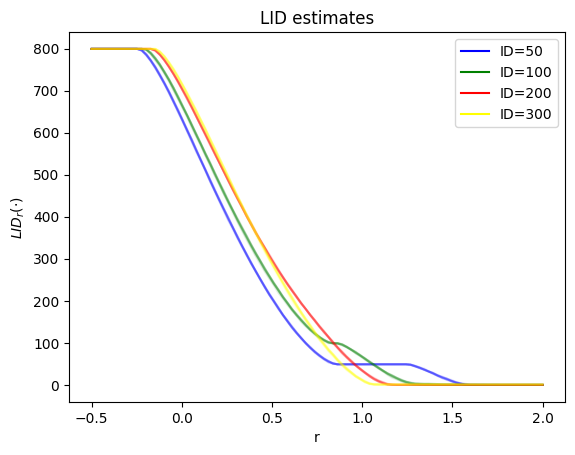

In [24]:

from matplotlib.lines import Line2D
import numpy as np


def plot_multiscale_lid_diffusion(
    datasets,
    r_begin,
    r_end,
    diffusion_models, 
    colors,
    limit_dataset: int = 100, 
):
    print(datasets)
    for idx, model in enumerate(diffusion_models):
        print(f"Calculating LID dataset [{idx+1}/{len(diffusion_models)}]")
        lid = []

        radii = np.linspace(r_begin, r_end, 100)
        first_time = True
        for r in tqdm(radii):
            all_lid = model.lid(
                datasets[idx].x[:limit_dataset].to(device), 
                r=r,
                num_samples=None,
                eps=0.001,
                use_cache=not first_time,
            )
            first_time = False
            lid.append(all_lid)
        lid = np.stack(lid).T
        for i in range(len(lid)):
            plt.plot(radii, lid[i], color=colors[idx], alpha=0.1)

    # Creating custom legend
    legend_elements = [Line2D([0], [0], color=colors[i], label=f'ID={manifold_dims[i]}') for i in range(len(colors))]

    # Adding the legend to the plot
    plt.legend(handles=legend_elements)

    # Adding titles and labels (optional)
    plt.title("LID estimates")
    plt.xlabel("r" )
    plt.ylabel("$LID_{r}(\\cdot)$")

    plt.show()
    

plot_multiscale_lid_diffusion(
    projected_datasets[:-1],
    -0.5,
    2,
    vesde_models[:-1], 
    ['blue', 'green', 'red', 'yellow'],#, 'black'],
    limit_dataset=10,
)